# Attempting to Crossmatch Lamost with Megan's Gaia-Kepler crossmatched catalog

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Coordinates of the Kepler field:

In [2]:
from astropy.coordinates import SkyCoord
c = SkyCoord('19h22m40s', '+44d30m00s', frame='icrs')
kepler_ra, kepler_dec = c.ra.value, c.dec.value
kepler_ra, kepler_dec

(290.6666666666667, 44.5)

Load the full LAMOST stellar catalog. Column descriptions are here: http://dr5.lamost.org/v3/doc/data-production-description#toc_16

In [3]:
# with fits.open("../../data/lamost_dr5_v3_stellar.fits") as data:
#     lamost_stellar = pd.DataFrame(data[1].data, dtype="float64")

In [4]:
# Column descriptions are here: http://dr5.lamost.org/v3/doc/data-production-description#toc_16
# for k in lamost_stellar.keys():
#     print(k)

In [5]:
# ndeg_ra = 12
# ndeg_dec = 10
# sky_mask = (kepler_ra-ndeg_ra < lamost_stellar.ra.values) & (lamost_stellar.ra.values < kepler_ra+ndeg_ra)
# sky_mask &= (kepler_dec-ndeg_dec < lamost_stellar.dec.values) & (lamost_stellar.dec.values < kepler_dec+ndeg_dec)
# lamost_kepler_sky = lamost_stellar.iloc[sky_mask]

# Load the lamost catalog that's near the Kepler footprint

In [6]:
lamost_kepler_sky = pd.read_csv("../data/lamost_near_kepler_footprint.csv")

In [13]:
np.array([k for k in lamost_kepler_sky.keys()])

array(['Unnamed: 0', 'obsid', 'designation', 'obsdate', 'lmjd', 'mjd',
       'planid', 'spid', 'fiberid', 'ra_obs', 'dec_obs', 'snru', 'snrg',
       'snrr', 'snri', 'snrz', 'objtype', 'class', 'subclass', 'z',
       'z_err', 'magtype', 'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6',
       'mag7', 'tsource', 'fibertype', 'tfrom', 'tcomment', 'offsets',
       'offset_v', 'ra', 'dec', 'teff', 'teff_err', 'logg', 'logg_err',
       'feh', 'feh_err', 'rv', 'rv_err'], dtype='<U11')

# Load the Gaia-Kepler crossmatch:

In [7]:
with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
    gaia3 = pd.DataFrame(data[1].data, dtype="float64")

In [14]:
np.array([k for k in gaia3.keys()])

array(['kepid', 'tm_designation', 'kepmag', 'teff', 'teff_err1',
       'teff_err2', 'teff_prov', 'logg', 'logg_err1', 'logg_err2',
       'logg_prov', 'feh', 'feh_err1', 'feh_err2', 'feh_prov', 'radius',
       'radius_err1', 'radius_err2', 'mass', 'mass_err1', 'mass_err2',
       'prov_sec', 'nconfp', 'nkoi', 'ntce', 'jmag', 'hmag', 'kmag',
       'planet?', 'solution_id', 'designation', 'source_id',
       'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_e

# Drop targets with multiple crossmatches.

In [40]:
def drop_multi_matches(df, ang_sep_column, duplicated_column):
    df_sorted = df.sort_values(by=ang_sep_column, ascending=True)
    df_dropped = df_sorted.drop_duplicates(subset=duplicated_column, keep="first")
    return df_dropped

2573 Stars with the same Kepler ID dropped
744 Stars with the same Gaia ID dropped


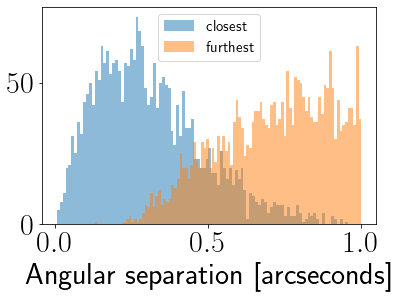

In [41]:
# If a target is duplicated, keep the one with the smallest angular separation.
# Sort targets by angular distance
gaia3_sorted = gaia3.sort_values(by="kepler_gaia_ang_dist", ascending=True)

# Plot the distribution of angular distances for the nearest and furthest duplicated stars
furthest = gaia3_sorted.duplicated(subset="kepid", keep="first")
closest = gaia3_sorted.duplicated(subset="kepid", keep="last")
plt.hist(gaia3_sorted.kepler_gaia_ang_dist.values[closest], 100, alpha=.5, label="closest");
plt.hist(gaia3_sorted.kepler_gaia_ang_dist.values[furthest], 100, alpha=.5, label="furthest");
plt.legend()
plt.xlabel("Angular separation [arcseconds]")

# Drop stars with the same Kepler ID
# gaia_dropped = gaia3_sorted.drop_duplicates(subset="kepid", keep="first")
gaia_dropped = drop_multi_matches(gaia3, "kepler_gaia_ang_dist", "kepid")

print(len(gaia3)-len(gaia_dropped), "Stars with the same Kepler ID dropped")

# Drop stars with the same Gaia ID
# gaia_dropped_sorted = gaia_dropped.sort_values(by="kepler_gaia_ang_dist")
# gaia = gaia_dropped_sorted.drop_duplicates(subset="source_id", keep="first")
gaia = drop_multi_matches(gaia_dropped, "kepler_gaia_ang_dist", "source_id")

print(len(gaia_dropped)-len(gaia), "Stars with the same Gaia ID dropped")

Save the single matches as a separate file.

In [39]:
gaia.to_csv("../data/gaia_kepler_unique_matches.csv")

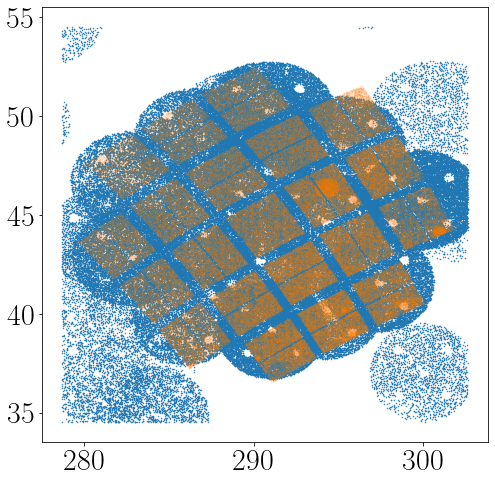

In [36]:
plt.figure(figsize=(8,8))
plt.plot(lamost_kepler_sky.ra, lamost_kepler_sky.dec, ".", ms=1, zorder=0)
plt.plot(gaia.ra, gaia.dec, ".", zorder=1, ms=1, alpha=.1)

In [37]:
lamost_coords = SkyCoord(lamost_kepler_sky.ra.values,
                         lamost_kepler_sky.dec.values, unit="deg")
len(lamost_coords)

198990

In [38]:
gaia_coords = SkyCoord(gaia.ra.values,
                       gaia.dec.values, unit="deg")
len(gaia_coords)

195134

In [21]:
lamost_edr3 = pd.read_csv("../data/LAMOST-EDR3_1arcsec_Xmatch.csv")
lamost_edr3_distances = pd.read_csv("../data/LAMOST-EDR3_distances_1arcsec_Xmatch.csv")

In [9]:
from astropy.coordinates import SkyCoord
c = SkyCoord('19h22m40s', '+44d30m00s', frame='icrs')
c.ra.value, c.dec.value

(290.6666666666667, 44.5)

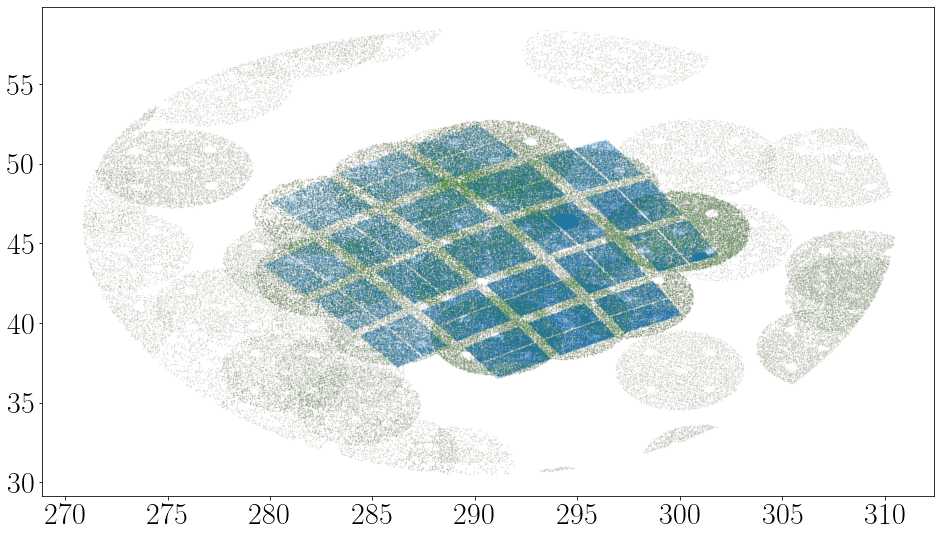

In [40]:
plt.figure(figsize=(16, 9))
plt.plot(gaia3.ra, gaia3.dec, ".", zorder=1, ms=1, alpha=.1)
# plt.plot(c.ra.value, c.dec.value, "o")
ndeg = 14
# plt.plot(c.ra.value+ndeg, c.dec.value+ndeg, "o")
# plt.plot(c.ra.value+ndeg, c.dec.value-ndeg, "o")
# plt.plot(c.ra.value-ndeg, c.dec.value-ndeg, "o")
# plt.plot(c.ra.value-ndeg, c.dec.value+ndeg, "o")
plt.plot(lamost_edr3.RAJ2000, lamost_edr3.DEJ2000, "C6.", zorder=0, ms=1, alpha=.1)
plt.plot(lamost_edr3_distances.RAJ2000, lamost_edr3_distances.DEJ2000, "C2.", zorder=0, ms=1, alpha=.1)

In [41]:
for k in lamost_edr3.keys():
    print(k)

angDist
_RAJ2000
_DEJ2000
RAJ2000
DEJ2000
Teff
e_Teff
q_Teff
logg
e_logg
q_logg
Vt
e_Vt
q_Vt
[Fe/H]
e_[Fe/H]
q_[Fe/H]
[C/Fe]
q_[C/Fe]
[N/Fe]
q_[N/Fe]
[O/Fe]
q_[O/Fe]
[Na/Fe]
q_[Na/Fe]
[Mg/Fe]
q_[Mg/Fe]
[Al/Fe]
q_[Al/Fe]
[Si/Fe]
q_[Si/Fe]
[Ca/Fe]
q_[Ca/Fe]
[Ti/Fe]
q_[Ti/Fe]
[Cr/Fe]
q_[Cr/Fe]
[Mn/Fe]
q_[Mn/Fe]
[Co/Fe]
q_[Co/Fe]
[Ni/Fe]
q_[Ni/Fe]
[Cu/Fe]
q_[Cu/Fe]
[Ba/Fe]
q_[Ba/Fe]
Mult
SubClass
LAMOST
ra_epoch2000
dec_epoch2000
errHalfMaj
errHalfMin
errPosAng
source_id
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
astrometric_n_good_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
pseudocolour
pseudocolour_error
visibility_periods_used
ruwe
duplicated_source
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_mag
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_mag
phot_rp_mean_flux
phot_rp_mean_mag
phot_bp_rp_excess_factor
bp_rp
dr2_radial_veloc

In [42]:
lamost_edr3.LAMOST

0         LAMOST
1         LAMOST
2         LAMOST
3         LAMOST
4         LAMOST
           ...  
258358    LAMOST
258359    LAMOST
258360    LAMOST
258361    LAMOST
258362    LAMOST
Name: LAMOST, Length: 258363, dtype: object